In [1]:
import random

import coarse_fine_volatility as cfvol
import gain_loss_asymetry as glasym
import gen_inv_gamma
import heavy_tails as hevytail
import leverage_effect as leveff
import linear_unpredictability as linupred
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import scipy.stats as stat
import torch
import visualize_stylized_facts as vsf
import volatility_clustering as vol_clust
from power_fit import fit_powerlaw

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

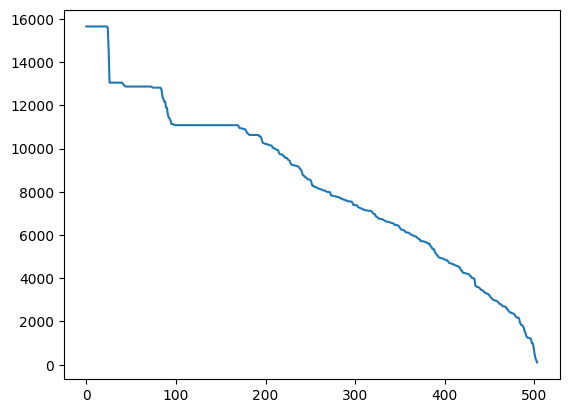

In [4]:
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= 4000].index
stocks = stocks.drop(["SPY"])  # drop the index

MMM     0
CVX     0
MO      0
KO      0
AEP     0
       ..
LULU    0
ULTA    0
MSCI    0
PM      0
V       0
Length: 431, dtype: int64
Shape: (4000, 431)


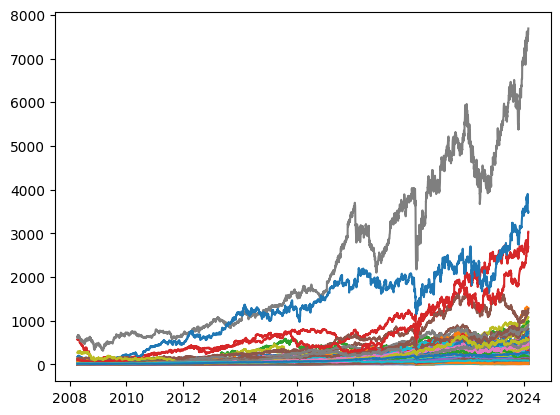

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-4000]
real_data = real_data.loc[first_date:, stocks]
print(np.sum(np.isnan(real_data), axis=0))
print(f"Shape: {real_data.shape}")
plt.plot(real_data)
plt.show()

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_log_price = np.cumsum(np_ret, axis=0)

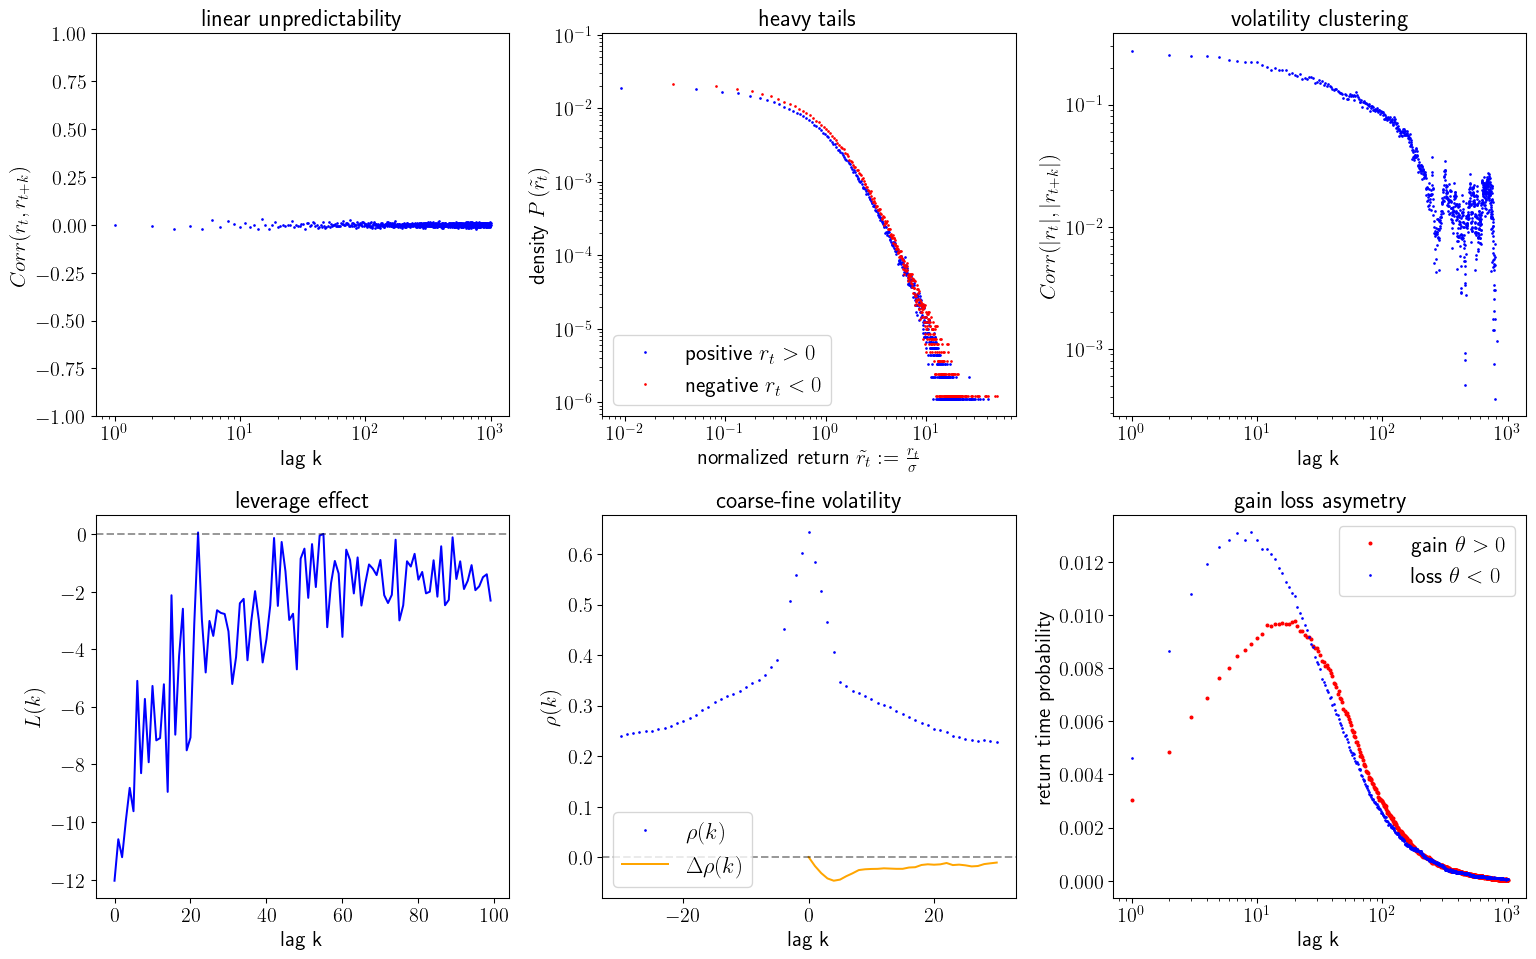

In [7]:
fig = vsf.visualize_stylized_facts(log_returns=np_ret)
plt.show()

In [8]:
lin_unpred = linupred.linear_unpredictability_statistics(
    log_returns=np_ret, max_lag=1000
)

-3.842363878578765
-3.3601326992663036


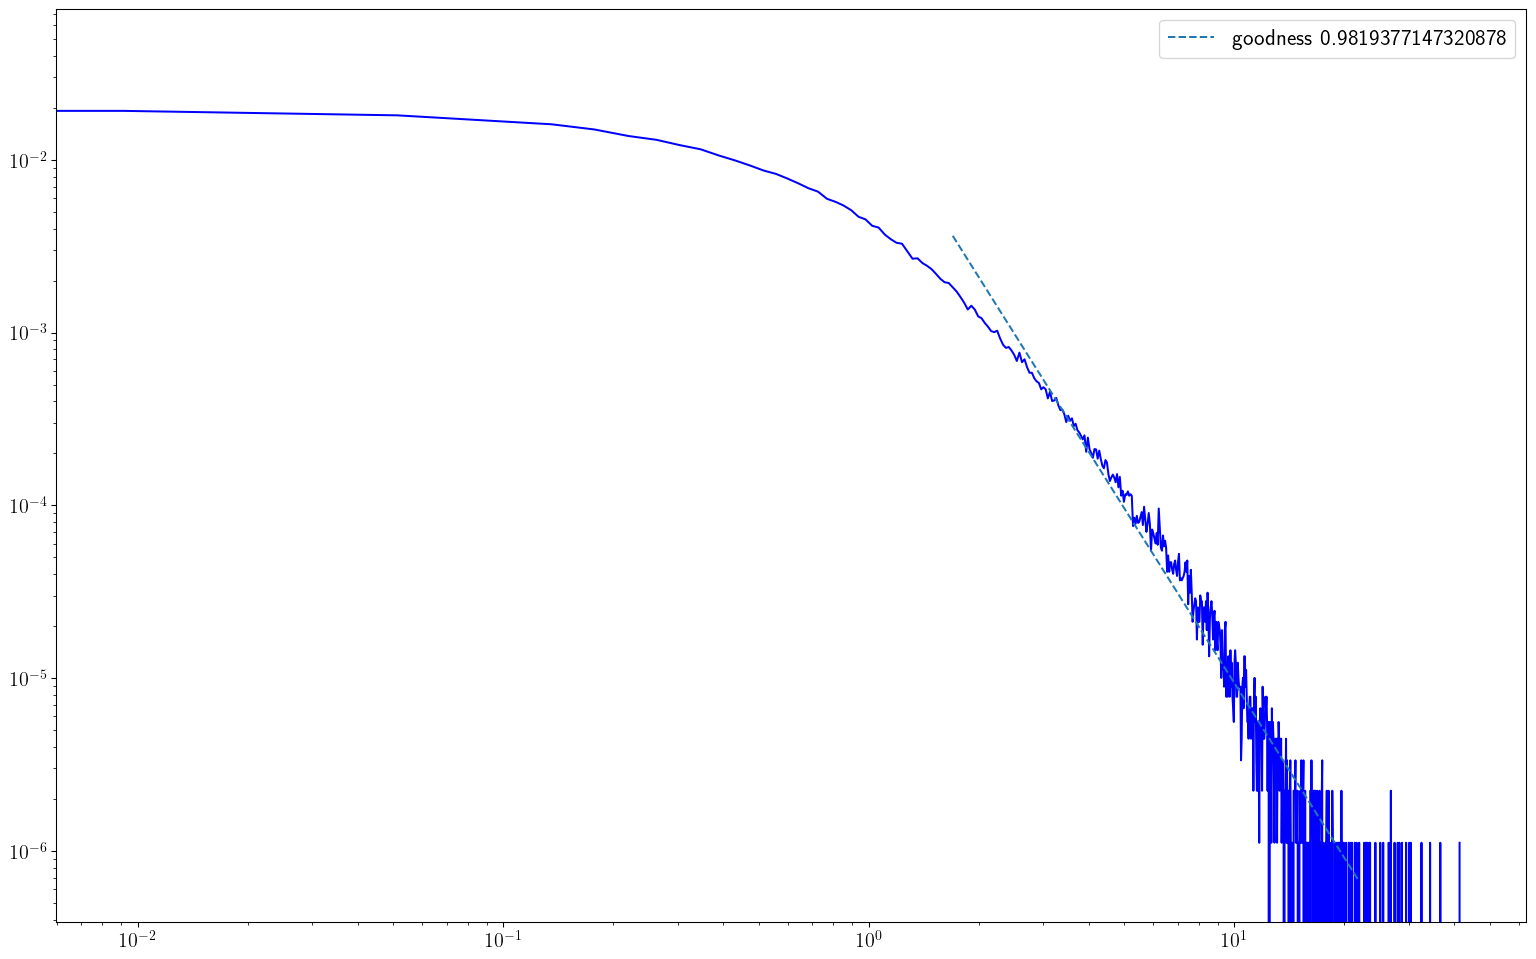

In [9]:
pos_y, pos_x, neg_y, neg_x = hevytail.heavy_tails(log_returns=np_ret, n_bins=1000)
pos_fit_x, pos_fit_y, alpha, beta, r = fit_powerlaw(pos_x, pos_y, optimize="both")
x_lin = np.linspace(np.min(pos_fit_x), np.max(pos_fit_x), num=1000)
y_lin = np.exp(alpha) * np.power(x_lin, beta)
# mask = (y_lin < np.max(pos_y)) & (y_lin > np.min(pos_y))
# x_lin = x_lin[mask]
# y_lin = y_lin[mask]
print(alpha)
print(beta)

plt.plot(pos_x, pos_y, c="blue")
plt.plot(x_lin, y_lin, label=f"goodness {r}", linestyle="--", alpha=1)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

alpha : -0.5884377817577506
beta -0.40890846181948365


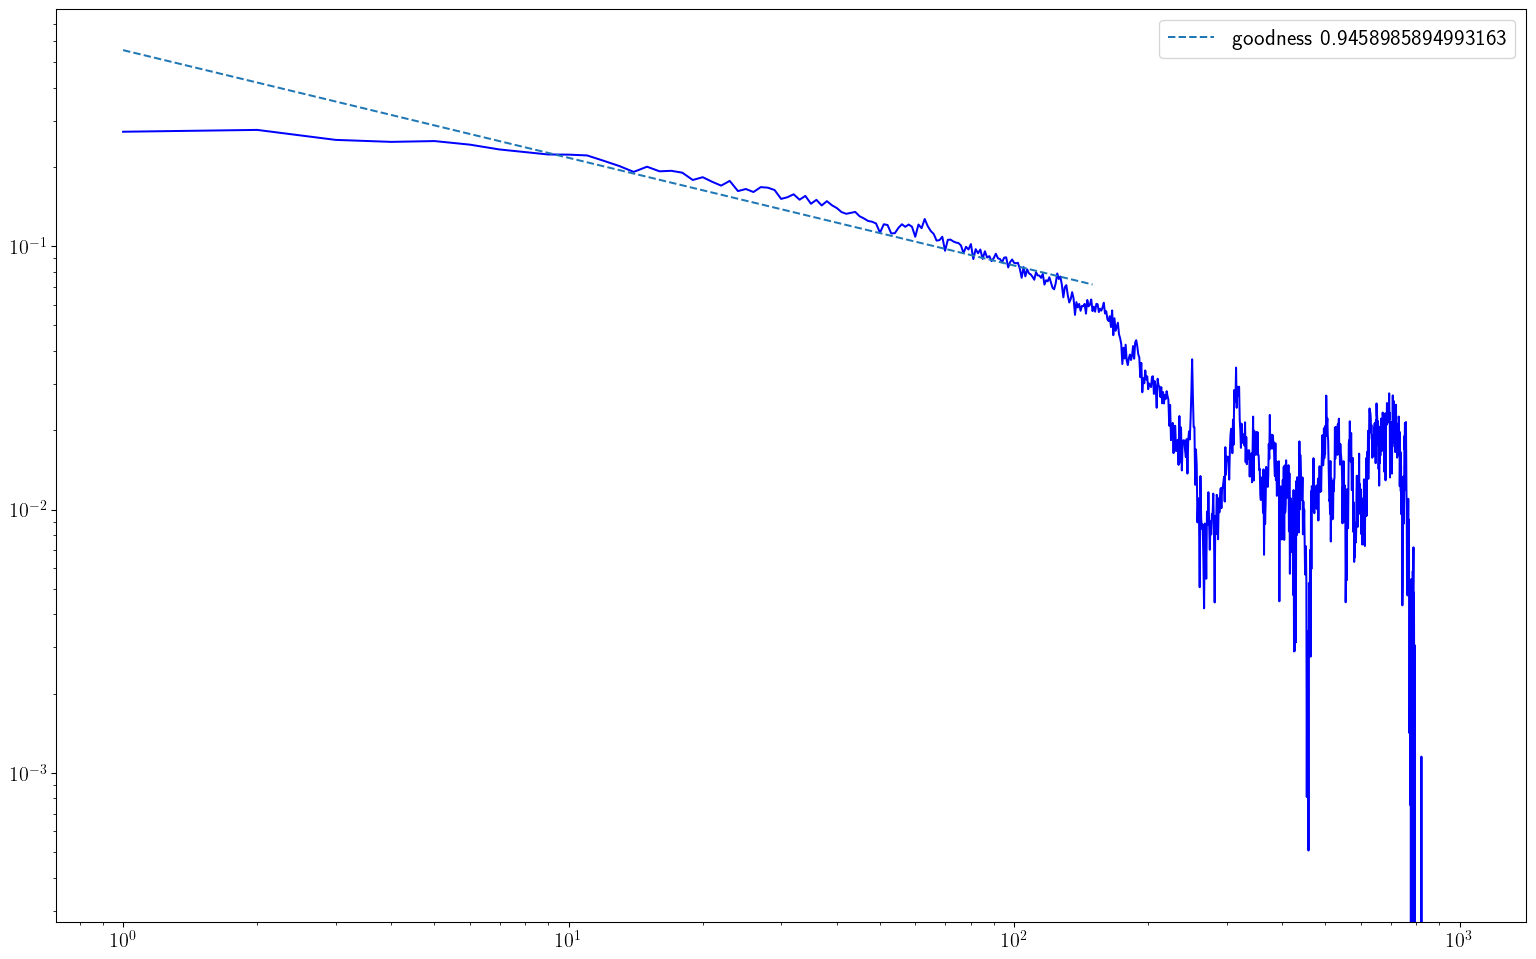

In [10]:
pos_y = vol_clust.volatility_clustering(log_returns=np_ret, max_lag=1000)
pos_y = np.mean(pos_y, axis=1)
pos_x = np.arange(1, pos_y.size + 1)
curr_x, curr_y, alpha, beta, r = fit_powerlaw(pos_x, pos_y, optimize="left")
x_lin = np.linspace(np.min(curr_x), np.max(curr_x), num=1000)
y_lin = np.exp(alpha) * np.power(x_lin, beta)
plt.plot(pos_x, pos_y, c="blue")
plt.plot(x_lin, y_lin, label=f"goodness {r}", linestyle="--", alpha=1)
print(f"alpha : {alpha}")
print(f"beta {beta}")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

alpha : 3.309492742748607
beta -0.7003182668339843


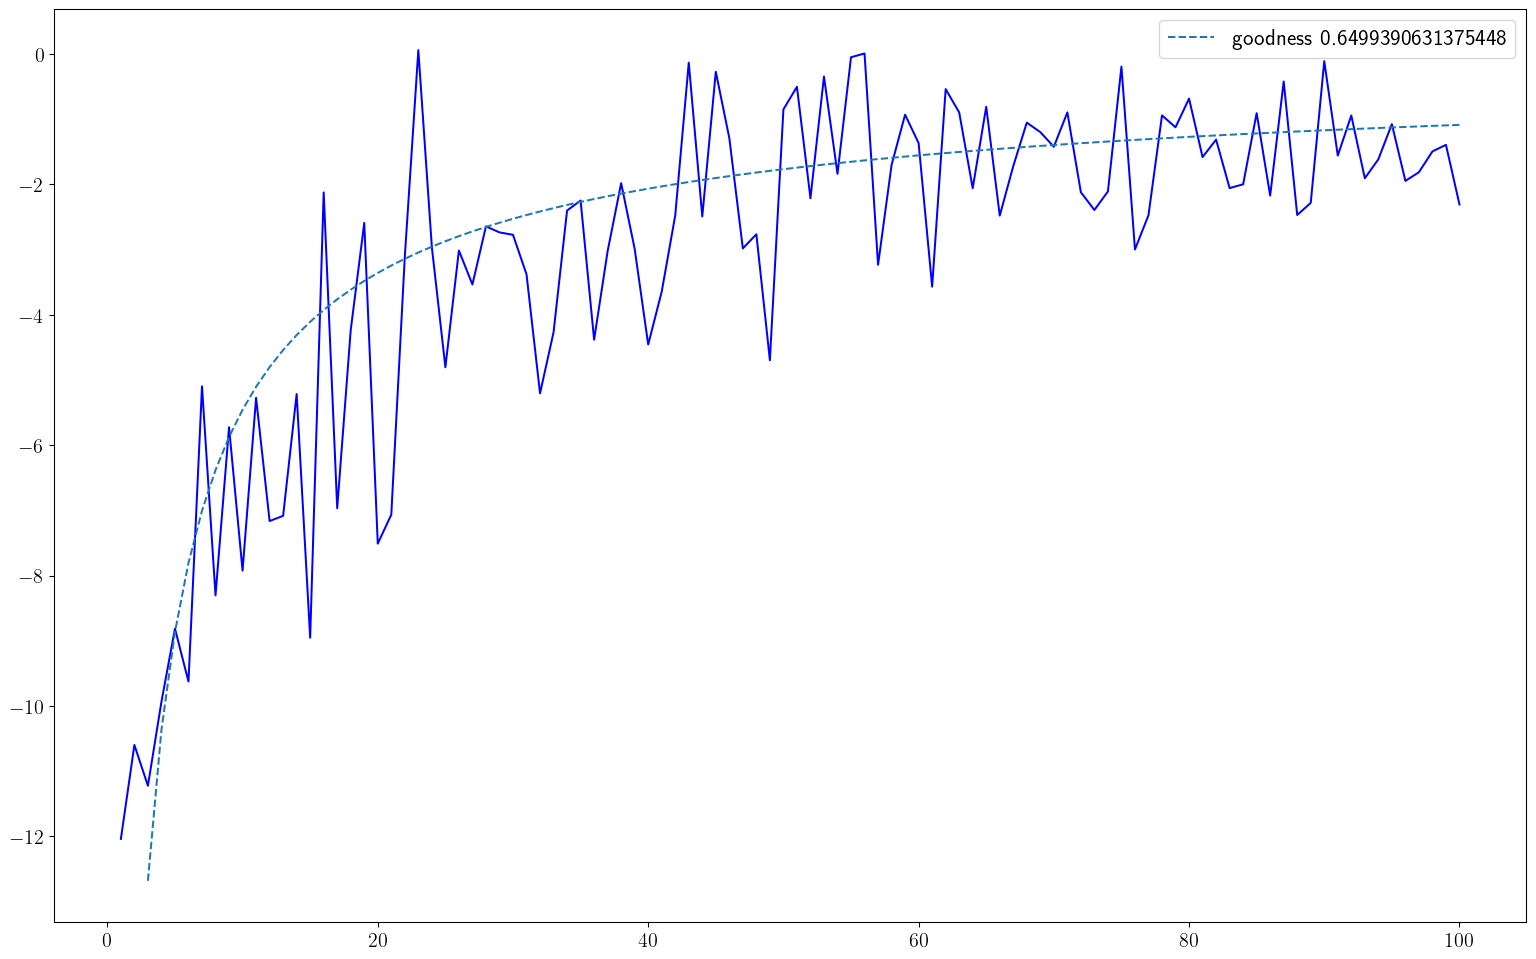

In [11]:
pos_y = leveff.leverage_effect(log_returns=np_ret, max_lag=100)
pos_y = np.mean(pos_y, axis=1)
pos_x = np.arange(1, pos_y.size + 1)
curr_x, curr_y, alpha, beta, r = fit_powerlaw(pos_x, -pos_y, optimize="none")
x_lin = np.linspace(np.min(curr_x), np.max(curr_x), num=100)
y_lin = -np.exp(alpha) * np.power(x_lin, beta)
plt.plot(pos_x, pos_y, c="blue")
plt.plot(x_lin[2:], y_lin[2:], label=f"goodness {r}", linestyle="--", alpha=1)
print(f"alpha : {alpha}")
print(f"beta {beta}")
plt.yscale("linear")
plt.xscale("linear")
plt.legend()
plt.show()

alpha : -0.03941676167643457
beta 0.0010445729737193037


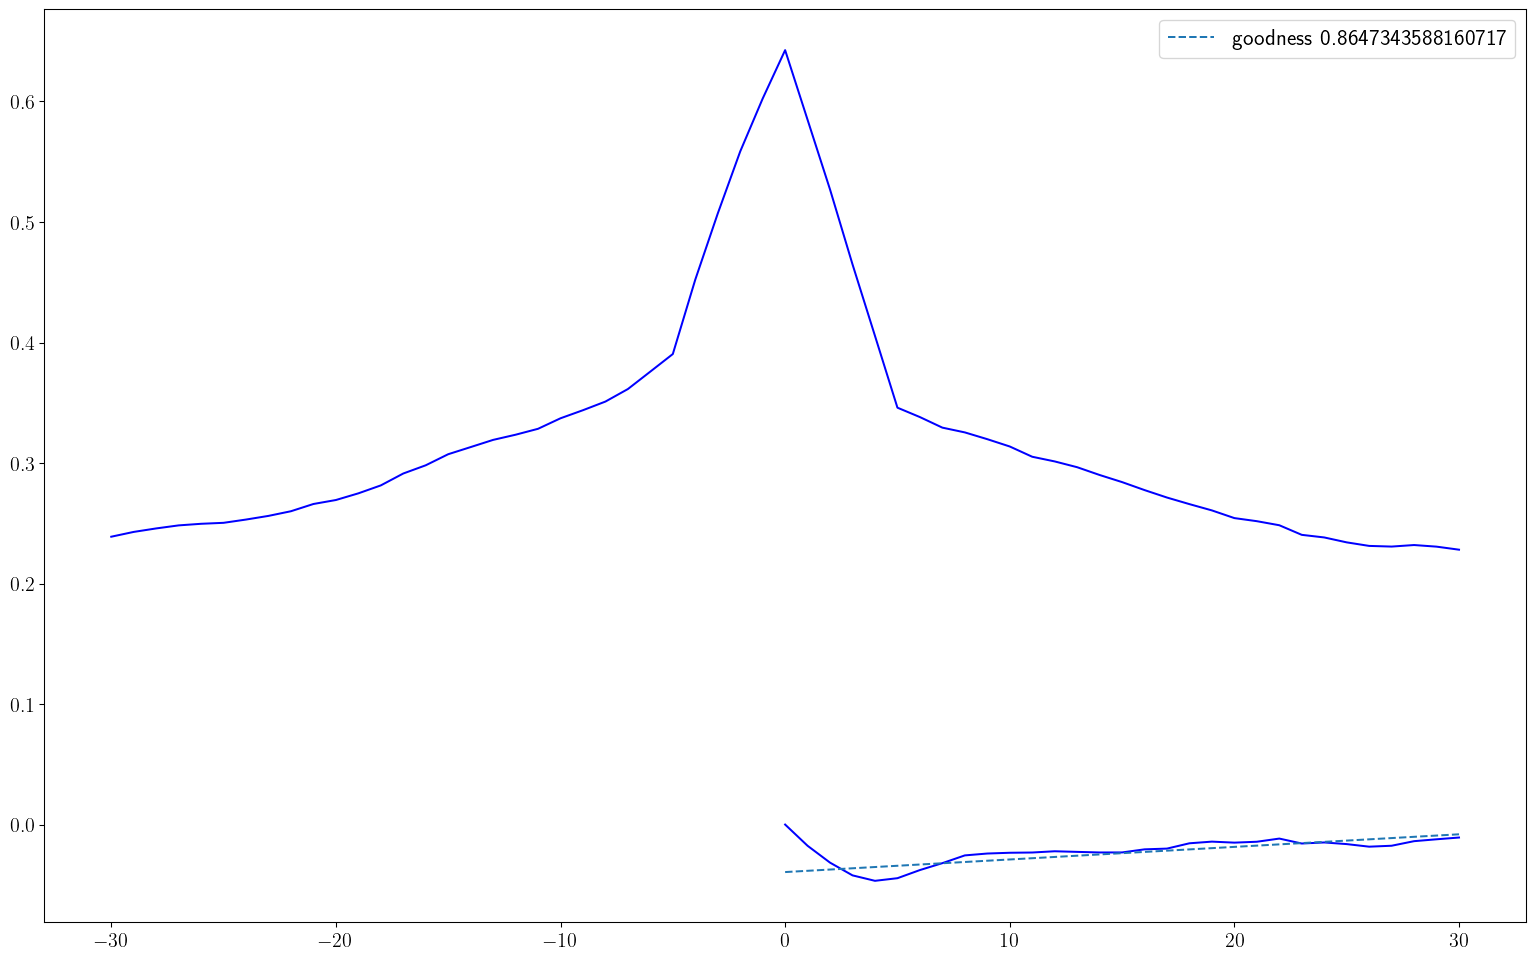

In [12]:
ll_data, ll_x, delta_ll_data, delta_ll_x = cfvol.corse_fine_volatility(
    log_returns=np_ret, tau=5, max_lag=30
)
pos_y = np.mean(delta_ll_data, axis=1)
pos_x = delta_ll_x
fit = stat.linregress(pos_x[3:], pos_y[3:])
alpha, beta, r = fit.intercept, fit.slope, fit.rvalue
x_lin = np.linspace(np.min(pos_x), np.max(pos_x), num=30)
y_lin = alpha + x_lin * beta
plt.plot(pos_x, pos_y, c="blue")
plt.plot(ll_x, np.mean(ll_data, axis=1), c="blue")
plt.plot(x_lin, y_lin, label=f"goodness {r}", linestyle="--", alpha=1)
print(f"alpha : {alpha}")
print(f"beta {beta}")
plt.yscale("linear")
plt.xscale("linear")
plt.legend()
plt.show()

In [13]:
gain_data, loss_data = glasym.gain_loss_asymmetry(
    log_price=np_log_price, max_lag=1000, theta=0.1
)
theta = gen_inv_gamma.fit_gen_inv_gamma(
    gain_data, [11.2, 2.4, 0.5, 4.5], method="Newton-CG"
)
x_lin = np.linspace(1, 1000, num=3000)
y_lin = gen_inv_gamma.gen_inf_gamma_pdf(x_lin, theta)
plt.plot(gain_data, c="blue", linestyle="none", marker="o")
plt.plot(x_lin, y_lin, linestyle="--", alpha=1)
plt.yscale("linear")
plt.xscale("linear")
plt.show()


KeyboardInterrupt

